# Decision Trees
We'll start by building a decision tree and examining how it works

In [10]:
from IPython.display import IFrame
import numpy as np

chapter_imgs = 'images/decision_trees/'
# IFrame(src='./nice.html', width=700, height=600)

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [3]:
# Where to save the figures
import os 

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

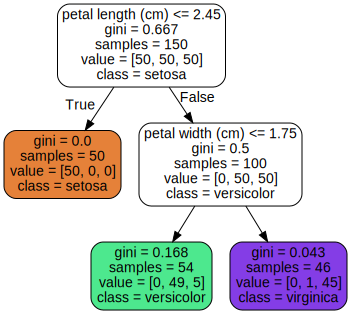

In [4]:
from sklearn.tree import export_graphviz
from graphviz import Source

export_graphviz(
    tree_clf, 
    out_file= os.path.join(IMAGES_PATH, "iris_tree.dot"),
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

By looking at the diagram above we can see how the decision tree makes a prediction. 

Suppose we find an iris flower with petal width <= 0.8cm. The first node evaluates to true, we move to a leaf node and find our class.

However if we find a flower with petal width >0.8 we move to the next node on the right. It is not a leaf node so we ask another question: is the petal width <= 1.75cm? If so we classify it as versicolor otherwise as virginica.

*Note*: One of the advantages of decision trees is that they need little to no data preparation, feature scaling or centering.

You'll note that each node has various attributes. Here's their definition

**samples:** How many training instances it applies to. E.g. 100 instances have petal width >= 0.8cm (depth 1, right) and of those 54 have petal width <= 1.75cm and 46 greater than that.

**value:** How many training instances of each class this node applies to. E.g. bottom right (purple) node applies to 0 *iris setosa*, 1 *iris versicolor* and *45 iris virginica*.

The **gini** attribute measures how *pure* a node is. A node is pure (gini=0) if all training instances it applies to belong to the same class.

For example the orange node has gini=0 because all training instances are *iris setosa* instances. More formally, the Gini impurity is defined as

$$ G_i = 1 - \sum^{n}_{k=1}p_{i,k}^2$$

Where $p_{i,k}$ is the ratio of class $k$ instances among the training instances in the $i^{th}$ node

For example, the green node has gini score equal to
$$ 1 - (0/54)^2 - (49/54)^2 - (5/54)^2 \approx 0.168 $$ 

In [6]:
scale = [0.00, 0.33, 0.66, 1.00]
c_colors = ['#9898ff', '#a0faa0', '#fafab0']
cscale = sorted(
    [(val, c) for val,c in zip(scale, c_colors)] +
    [(val, c) for val,c in zip(scale[1:], c_colors)]
)

In [40]:
import plotly.graph_objects as go
from plotly.validators.scatter.marker import SymbolValidator

def plot_decision_boundary(clf, X, y, fname, axes=[0, 7.5, 0, 3], iris=True, 
                           legend=False, plot_training=True, target_names=iris['target_names']):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = tree_clf.predict(X_new).reshape(x1.shape)
    
    scale = [0.00, 0.33, 0.66, 1.00]
    c_colors = ['#9898ff', '#a0faa0', '#fafab0']
    cscale = sorted(
        [(val, c) for val,c in zip(scale, c_colors)] +
        [(val, c) for val,c in zip(scale[1:], c_colors)]
    )
    
    fig = go.Figure(
        go.Contour(
            x = x1s, y = x2s, z = y_pred,
            showscale = False, opacity = 0.3,
            colorscale = cscale),
        layout=go.Layout(
            title = 'Decision Tree boundaries',
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))
    )
    if not iris:
        c_colors = sorted(["#7d7d58", "#4c4c7f", "#507d50"])
        cscale = sorted(
            [(val, c) for val,c in zip(scale, c_colors)] +
            [(val, c) for val,c in zip(scale[1:], c_colors)]
        )
        fig.add_trace(
            go.Contour(
                x = x1s, y = x2s, z = y_pred,
                showscale = False, opacity = 0.3,
                colorscale = cscale,
                contours_coloring='lines'))

    if iris:
        fig.update_layout(xaxis_title='Petal length', yaxis_title='Petal width')
        fig.add_trace(
            go.Scatter(
                x=[1.4, 3.2, 4.05],
                y=[1.0, 1.8, 0.5],
                mode="text",
                text=["Depth=0", "Depth=1", "Depth=2"],
                showlegend=False))
        fig.add_scatter(
            x = [2.45, 2.45], y=[0, 3], showlegend=False, mode='lines',
            line=dict(width=2, color='black')
        )
        fig.add_scatter(
            x = [2.45, 7.5], y=[1.75, 1.75], showlegend=False, mode='lines',
            line=dict(dash='dot', width=2, color='black')
        )
    else:
        fig.update_layout(xaxis_title='$x_1', yaxis_title='$x_2$')
    if plot_training:
        num_classes = len(target_names)
        symbols = SymbolValidator().values[:8*num_classes:8]
        colors = ['blue', 'green', 'orange']
        for idx, species, symb, c in zip(range(num_classes), target_names, symbols, colors):
            fig.add_scatter(
                x = X[:, 0][y == idx],
                y = X[:, 1][y == idx],
                name = species, 
                mode = 'markers', marker_symbol = symb, marker_color = c
            )
        fig.write_html(chapter_imgs + fname)

In [41]:
plot_decision_boundary(tree_clf, X, y, fname='iris_boundaries.html')
IFrame(src=chapter_imgs+'iris_boundaries.html', width=900, height=600)

In the image above we can see the decision tree boundaries. The solid black line represents the split of the root node. Since the blue area is pure, it cannot be split any further. 

The decision tree then performs it's second split at width=1.75, represented by the dotted line. Since we set max depth=2, there are no more splits, however increasing depth increases the fit.

Decision Trees are an example of a *White box* model. It is easy to understand and explain why it makes its decision. In contrast, Random Forests and Neural Nets are highly accurate, but very hard to explain, and are called *black box* models.

### Class Probabilities

Decision trees can estimate the probability an instance belongs to a class *k* as follows.

- Traverse to the the leaf node for this instance
- Return ratio of training instances of class *k* in this node

For example, if we found a flower with petal length 5 and petal width 1.5 we get the following

In [59]:
for proba, cls in zip(tree_clf.predict_proba([[5, 1.5]])[0], iris['target_names']):
    print(f'Class {cls} probability: {proba:0.3f}')
    
print("Prediction class: ", tree_clf.predict([[5, 1.5]]))

Class setosa probability: 0.000
Class versicolor probability: 0.907
Class virginica probability: 0.093
Prediction class:  [1]


Note that any new instance that probabilities are identical for any instance located in a leaf node.

## The CART algorithm

Scikit-Learn uses the *Classification and Regression Tree* algorithm. It works as follows

Split the training set in two using a single feature $k$ and threshold $t_k$. To choose $k$ and $t_k$, search for the pair $(k, t_k)$ that produces the purest subsets (wieghted by size). The equation to be minimized is 

$$ J(k, t_k) = \frac{m_{\text{left}}}{m}G_{\text{left}} + \frac{m_{\text{right}}}{m}G_{\text{right}} $$

where $$\begin{cases} 
        G_{\text{left/right}} & \text{measures the impurity of the left/right subset}\\
        m_{\text{left/right}} & \text{number of instances on the left/right subset}
        \end{cases}$$


Once this first split is done, it recursively splits the subsets using the same logic, stopping recusion once it reaches maximum depth (hyperparameter) or it cannot find a split that will reduce impurity.

Some other parameters that control stopping conditions are *min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_leaf_nodes*

The CART Algorithm is an example of a greedy algorithm. It searches for the optimal split at the top leve, not caring whether that will happen several splits later. A greedy algorithm produces a solution that is good, but not guaranteed to be optimal. Finding the optimal tree is known to be an NP-Complete problem.

### Computational Complexity

To make a prediction, we need to traverse a tree. Decision Trees are approximately balanced thus has roughly $O(\log_2{m})$ nodes. Since each node requires only checking one feature, the overall complexity is $O(\log_2{m})$. Thus predictions are very fast.

The algorithm compares at most all features (less if *max_features* is set). It does so on all samples at each node resulting in $O(n\times m\log_2{m})$ complexity.

For small training sets, you can pre-sort the data (pre-sort=True), but this slows down training considerably for large training sets.